# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.9.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)).

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})
plt.style.use("seaborn")

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
batch_vectorizer = artm.BatchVectorizer(
    data_path="./data/lectures.txt",
    data_format="vowpal_wabbit",
    target_folder="./data/lectures_batches", 
    batch_size=100
)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]

model_artm = artm.ARTM(
    num_topics=T,
    topic_names=topic_names,
    class_ids={"text":1, "author": 1},
    num_document_passes=1,
    cache_theta=True,
    seed=-1,
)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [6]:
dictionary = artm.Dictionary(name='dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [7]:
model_artm.initialize(dictionary=dictionary)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [8]:
model_artm.scores.add(artm.TopTokensScore(name="top_words_text", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_words_author", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [9]:
SSR = artm.SmoothSparsePhiRegularizer(
    name='SparsePhi',
    tau=1000,
    class_ids="text",
    topic_names="bcg"
)
SSR.dictionary_name = "dictionary"
model_artm.regularizers.add(SSR)

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [10]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [11]:
SSR = artm.SmoothSparsePhiRegularizer(
    name='SparsePhi2',
    tau=-100,
    class_ids="text",
    topic_names=topic_names[:-1]

)
SSR.dictionary_name = "dictionary"
model_artm.regularizers.add(SSR)

Выполните еще 15 проходов по коллекции.

In [12]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [13]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ', end=" ")
    for word in model_artm.score_tracker["top_words_text"].last_tokens[topic_name]:
        print(word, end=" ")
    print()

sbj0:  свой быть его русский конечно век отношение власть александр писать написать имя историк римский король 
sbj1:  очень много поэтому такой там что раз интересный находиться высокий земля планета элемент условие тело 
sbj2:  такой система чтобы один между этот создавать общий сложный простой движение трудность 
sbj3:  как что начинать современный где себя сторона чем говорить это возникать другой когда 
sbj4:  если должный даже вид один появляться давать каждый это себя или любой вещь иной функция 
sbj5:  быть можно при получать структура сделать достаточно использовать материал свойство для пора применение углерод электронный 
sbj6:  она быть что говорить потому этот книга научный как выходить тема автор фильм 
sbj7:  тот человек именно сам который социальный после общество знание принимать степень род социология смерть социологический 
sbj8:  какой наука новый рассказывать процесс как доктор различный это связь каков развиваться использоваться наиболее химический 
sbj9:  теория 

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [14]:
sbj_topic_labels = [
    "История",
    "Астрономия",
    "Кинематика",
    "Начинания",
    "Виды",
    "Физика углеродных частиц",
    "Литература",
    "Социология",
    "Химия",
    "Физика поля",
    "Робот",
    "Пациент",
    "Эволюция",
    "Кандидат",
    "Космос",
    "Информация",
    "Группа",
    "Политика",
    "Речь",
    "Школа",
    "Технологии",
    "Семейные проблемы",
    "Форма",
    "Задача",
    "История религии",
    "Лингвистика",
    "Психология",
    "Биология",
    "Разработка",
]
topic_labels = sbj_topic_labels + ["Фоновая тема"]
topics_dict = dict(zip(topic_names, topic_labels))

In [15]:
print(len(topic_labels))

30


##### Анализ тем

In [16]:
topics_dict

{'sbj0': 'История',
 'sbj1': 'Астрономия',
 'sbj2': 'Кинематика',
 'sbj3': 'Начинания',
 'sbj4': 'Виды',
 'sbj5': 'Физика углеродных частиц',
 'sbj6': 'Литература',
 'sbj7': 'Социология',
 'sbj8': 'Химия',
 'sbj9': 'Физика поля',
 'sbj10': 'Робот',
 'sbj11': 'Пациент',
 'sbj12': 'Эволюция',
 'sbj13': 'Кандидат',
 'sbj14': 'Космос',
 'sbj15': 'Информация',
 'sbj16': 'Группа',
 'sbj17': 'Политика',
 'sbj18': 'Речь',
 'sbj19': 'Школа',
 'sbj20': 'Технологии',
 'sbj21': 'Семейные проблемы',
 'sbj22': 'Форма',
 'sbj23': 'Задача',
 'sbj24': 'История религии',
 'sbj25': 'Лингвистика',
 'sbj26': 'Психология',
 'sbj27': 'Биология',
 'sbj28': 'Разработка',
 'bcg': 'Фоновая тема'}

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [17]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
phi_a = model_artm.get_phi(class_ids="author")
theta = model_artm.get_theta()

In [18]:
phi_a

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
Александр_Четверин,0.000000e+00,0.000000e+00,2.430324e-10,0.000000e+00,3.550547e-14,1.341664e-02,8.532754e-14,0.000000e+00,3.043732e-05,0.000000,...,7.189442e-13,5.045514e-10,8.613470e-10,0.000000e+00,0.000000e+00,2.423772e-14,7.353013e-11,1.794466e-06,7.784436e-03,0.000000e+00
Сергей_Деев,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.458348e-02,0.000000,...,3.109168e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Роман_Мизюк,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.010587,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Николай_Борисов,0.000000e+00,0.000000e+00,3.631427e-07,2.492523e-15,4.843633e-15,0.000000e+00,1.181433e-14,0.000000e+00,1.936943e-06,0.000000,...,1.121914e-11,5.433083e-06,2.382453e-11,1.401149e-14,0.000000e+00,0.000000e+00,0.000000e+00,6.421392e-10,4.682046e-10,2.939675e-03
Галина_Ершова,0.000000e+00,0.000000e+00,1.671648e-09,2.960172e-12,0.000000e+00,1.575471e-16,1.794344e-15,0.000000e+00,3.174371e-08,0.000000,...,1.474777e-14,0.000000e+00,0.000000e+00,4.243396e-14,4.787457e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.829050e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Дарья_Радченко,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,3.464595e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Алексей_Лебедев,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,1.039379e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Александр_Гофман,0.000000e+00,0.000000e+00,0.000000e+00,1.694812e-16,3.729527e-16,0.000000e+00,1.376835e-16,8.373510e-02,1.689563e-15,0.000000,...,7.374215e-15,1.537321e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.288493e-16,0.000000e+00,0.000000e+00,1.031016e-13
Иван_Болдырев,8.863763e-13,0.000000e+00,3.502526e-07,6.011403e-05,1.333018e-07,7.909337e-13,3.144556e-04,8.752134e-08,3.250042e-05,0.000000,...,3.890079e-04,1.693306e-06,2.461723e-06,1.325750e-07,1.203483e-12,3.135537e-08,5.277478e-10,0.000000e+00,1.472468e-10,1.912690e-03


In [19]:
theta

,http://postnauka.ru/video/10006,http://postnauka.ru/video/10379,http://postnauka.ru/video/10380,http://postnauka.ru/video/10381,http://postnauka.ru/video/10382,http://postnauka.ru/video/10383,http://postnauka.ru/video/10384,http://postnauka.ru/video/10385,http://postnauka.ru/video/10473,http://postnauka.ru/video/10475,...,http://postnauka.ru/video/50088,http://postnauka.ru/video/50090,http://postnauka.ru/video/50097,http://postnauka.ru/video/50123,http://postnauka.ru/video/50340,http://postnauka.ru/video/50343,http://postnauka.ru/video/50345,http://postnauka.ru/video/50347,http://postnauka.ru/video/50349,http://postnauka.ru/video/50350
sbj0,0.038410,0.000000e+00,0.025883,4.204807e-02,0.003432,0.000000e+00,3.539717e-03,0.000000,0.000000,0.000000,...,0.009523,0.005088,0.033451,0.007528,0.007672,0.017517,0.009011,0.009866,0.009640,0.057097
sbj1,0.000062,0.000000e+00,0.024474,0.000000e+00,0.000000,3.120354e-02,0.000000e+00,0.001584,0.000000,0.000000,...,0.025212,0.020869,0.015721,0.022593,0.094523,0.018298,0.022048,0.014283,0.022331,0.022368
sbj2,0.000000,4.345238e-02,0.000000,3.029607e-02,0.000000,3.123556e-02,0.000000e+00,0.005124,0.000000,0.002420,...,0.019156,0.027589,0.012692,0.016199,0.021123,0.019633,0.026509,0.024465,0.032577,0.011100
sbj3,0.017788,8.864643e-02,0.013347,4.593863e-02,0.014015,2.596280e-02,1.911200e-02,0.033695,0.030569,0.040754,...,0.016713,0.012872,0.018203,0.017674,0.017722,0.023645,0.019720,0.020162,0.016937,0.014229
sbj4,0.117110,2.057703e-03,0.001101,1.434157e-03,0.006375,1.478974e-03,1.478974e-03,0.001392,0.001392,0.001315,...,0.019350,0.022434,0.022533,0.015265,0.006515,0.015959,0.017154,0.023134,0.021816,0.014870
sbj5,0.005410,1.736832e-01,0.049776,0.000000e+00,0.034566,3.124047e-02,4.405536e-03,0.000000,0.058795,0.027755,...,0.030291,0.020218,0.015039,0.030489,0.040794,0.012214,0.035996,0.021944,0.040157,0.020259
sbj6,0.001551,1.753833e-03,0.007918,1.222368e-03,0.005728,1.260567e-03,4.646887e-03,0.009854,0.001186,0.004791,...,0.029912,0.020553,0.025798,0.016847,0.013819,0.026565,0.016960,0.015515,0.017552,0.015678
sbj7,0.000000,0.000000e+00,0.000000,3.408916e-05,0.020424,0.000000e+00,0.000000e+00,0.029391,0.000000,0.000000,...,0.018135,0.028328,0.025444,0.016471,0.010343,0.035807,0.014781,0.034269,0.022542,0.013985
sbj8,0.195211,1.337893e-01,0.119428,1.396404e-01,0.212303,1.274028e-01,2.244731e-01,0.173486,0.119878,0.088644,...,0.009522,0.004645,0.010947,0.014965,0.024949,0.016270,0.024531,0.013812,0.014334,0.009515
sbj9,0.000000,1.020262e-08,0.000000,0.000000e+00,0.000000,6.773219e-02,0.000000e+00,0.029374,0.029384,0.000000,...,0.003410,0.020154,0.000919,0.012890,0.020468,0.011282,0.008938,0.004590,0.008471,0.002276


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

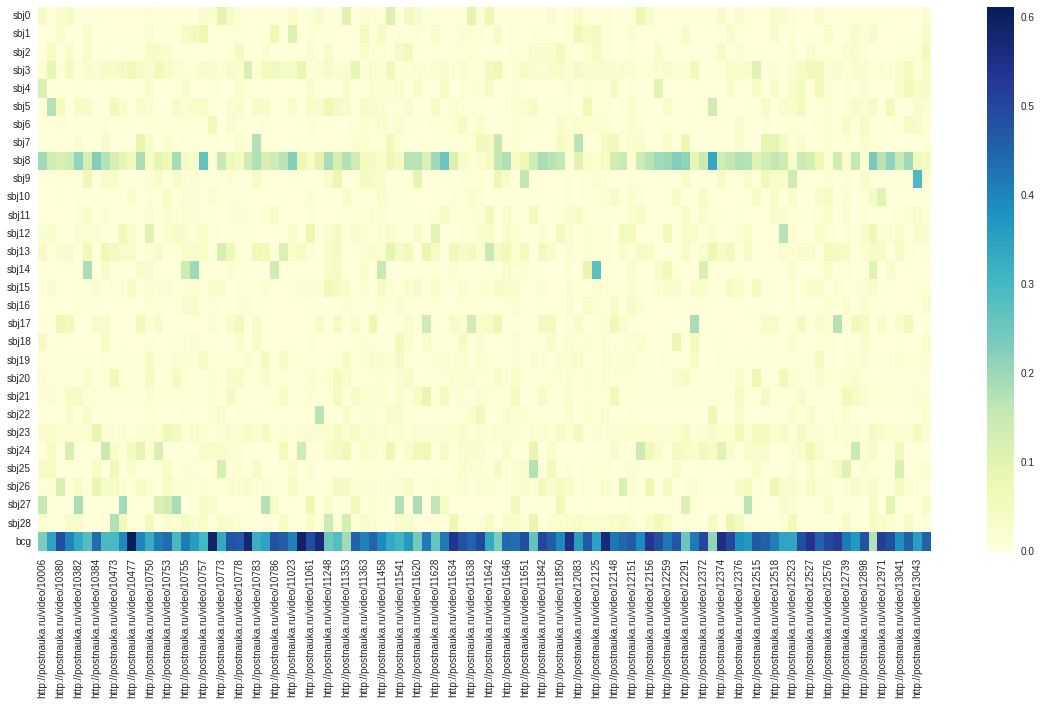

In [20]:
plt.figure(figsize=(20, 10))
seaborn.heatmap(data=theta.iloc[:,:100], cmap='YlGnBu')
plt.show()

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [21]:
pt = pd.DataFrame(theta.sum(axis=1))
pt

,0
sbj0,26.198532
sbj1,31.524466
sbj2,26.487547
sbj3,35.836452
sbj4,30.096607
sbj5,30.205622
sbj6,27.727449
sbj7,30.000689
sbj8,76.148033
sbj9,37.187412


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [22]:
print("Most popular topics:\n")
for sub, score in list(theta.sum(axis=1).sort_values(ascending=False)[:6].items()):
    print(f"sub: {topics_dict[sub]}")
    print(f"score: {score}")
    print(f"---")

Most popular topics:

sub: Фоновая тема
score: 789.3396606445312
---
sub: Химия
score: 76.14803314208984
---
sub: Кандидат
score: 40.354862213134766
---
sub: Космос
score: 38.14925765991211
---
sub: Физика поля
score: 37.18741226196289
---
sub: Начинания
score: 35.83645248413086
---


In [23]:
print("Least popular topics:\n")
for sub, score in list(theta.sum(axis=1).sort_values()[:3].items()):
    print(f"sub: {topics_dict[sub]}")
    print(f"score: {score}")
    print(f"---")

Least popular topics:

sub: Биология
score: 25.406665802001953
---
sub: История
score: 26.198532104492188
---
sub: Кинематика
score: 26.487546920776367
---


Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

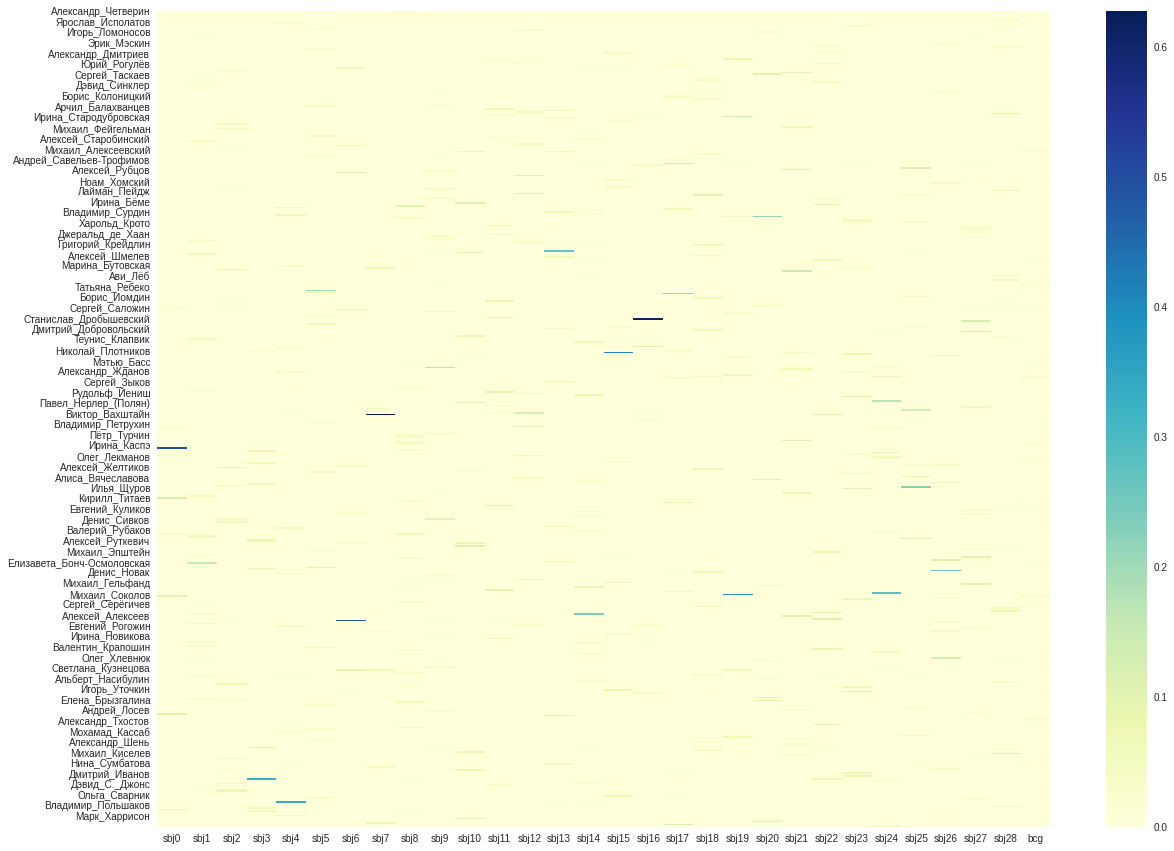

In [24]:
plt.figure(figsize=(20, 15))
seaborn.heatmap(data=phi_a, cmap='YlGnBu')
plt.show()

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [25]:
pd.DataFrame(phi_a[phi_a > 0.01].count(axis=1)[phi_a[phi_a > 0.01].count(axis=1) >= 3])

,0
Кирилл_Мартынов,3
Борис_Миркин,3
Гасан_Гусейнов,3
Сергей_Киселев,3
Михаил_Соколов,3
Александр_Филиппов,3
Мануэль_Маццара,3


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [26]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [27]:
pt

,0
sbj0,26.198532
sbj1,31.524466
sbj2,26.487547
sbj3,35.836452
sbj4,30.096607
sbj5,30.205622
sbj6,27.727449
sbj7,30.000689
sbj8,76.148033
sbj9,37.187412


In [28]:
phi_a

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
Александр_Четверин,0.000000e+00,0.000000e+00,2.430324e-10,0.000000e+00,3.550547e-14,1.341664e-02,8.532754e-14,0.000000e+00,3.043732e-05,0.000000,...,7.189442e-13,5.045514e-10,8.613470e-10,0.000000e+00,0.000000e+00,2.423772e-14,7.353013e-11,1.794466e-06,7.784436e-03,0.000000e+00
Сергей_Деев,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.458348e-02,0.000000,...,3.109168e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Роман_Мизюк,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.010587,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Николай_Борисов,0.000000e+00,0.000000e+00,3.631427e-07,2.492523e-15,4.843633e-15,0.000000e+00,1.181433e-14,0.000000e+00,1.936943e-06,0.000000,...,1.121914e-11,5.433083e-06,2.382453e-11,1.401149e-14,0.000000e+00,0.000000e+00,0.000000e+00,6.421392e-10,4.682046e-10,2.939675e-03
Галина_Ершова,0.000000e+00,0.000000e+00,1.671648e-09,2.960172e-12,0.000000e+00,1.575471e-16,1.794344e-15,0.000000e+00,3.174371e-08,0.000000,...,1.474777e-14,0.000000e+00,0.000000e+00,4.243396e-14,4.787457e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.829050e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Дарья_Радченко,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,3.464595e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Алексей_Лебедев,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,1.039379e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Александр_Гофман,0.000000e+00,0.000000e+00,0.000000e+00,1.694812e-16,3.729527e-16,0.000000e+00,1.376835e-16,8.373510e-02,1.689563e-15,0.000000,...,7.374215e-15,1.537321e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.288493e-16,0.000000e+00,0.000000e+00,1.031016e-13
Иван_Болдырев,8.863763e-13,0.000000e+00,3.502526e-07,6.011403e-05,1.333018e-07,7.909337e-13,3.144556e-04,8.752134e-08,3.250042e-05,0.000000,...,3.890079e-04,1.693306e-06,2.461723e-06,1.325750e-07,1.203483e-12,3.135537e-08,5.277478e-10,0.000000e+00,1.472468e-10,1.912690e-03


In [29]:
from tqdm import tqdm

rows = []
for topic in tqdm(list(pt.index)):
    row = {"topic": topic}
    for author in list(phi_a.index):
        numerator = phi_a.loc[author][topic] * float(pt.loc[topic])
        denumerator = sum(np.array(phi_a.loc[author]) * np.array(pt[0]))
        row[author] = numerator / denumerator
    rows.append(row)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.33it/s]


In [30]:
pta = pd.DataFrame.from_records(rows, index="topic")

In [31]:
pta

,Александр_Четверин,Сергей_Деев,Роман_Мизюк,Николай_Борисов,Галина_Ершова,Александр_Шварцбург,Сергей_Карабасов,Ярослав_Исполатов,Герберт_Хупперт,Сергей_Гашков,...,Олег_Мельник,Армен_Сергеев,Наталья_Смолянская,Марк_Харрисон,Сергей_Соколовский,Дарья_Радченко,Алексей_Лебедев,Александр_Гофман,Иван_Болдырев,Кирилл_Разлогов
topic,,,,,,,,,,,,,,,,,,,,,
sbj0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,4.766089e-12,0.000000e+00
sbj1,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.860993e-05,0.000000e+00,...,0.000000e+00,0.000000e+00,5.227764e-14,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,4.423341e-15
sbj2,9.493888e-09,0.000000e+00,0.0,4.144683e-06,9.586321e-09,0.000000e+00,1.440942e-08,3.128560e-06,0.000000e+00,1.527417e-14,...,0.000000e+00,4.449755e-13,0.000000e+00,5.391586e-09,0.000000e+00,0.0,0.0,0.000000e+00,1.904102e-06,6.475216e-11
sbj3,0.000000e+00,0.000000e+00,0.0,3.848897e-14,2.296716e-11,0.000000e+00,4.680711e-13,2.006917e-10,0.000000e+00,0.000000e+00,...,0.000000e+00,6.961520e-11,1.437117e-01,8.043117e-10,7.085271e-08,0.0,0.0,2.417730e-15,4.421482e-04,7.885034e-05
sbj4,1.575981e-12,0.000000e+00,0.0,6.281465e-14,0.000000e+00,1.029784e-13,9.934717e-12,9.999729e-01,0.000000e+00,8.082721e-11,...,0.000000e+00,2.528377e-15,8.558714e-01,2.240480e-08,4.071807e-07,0.0,0.0,4.468200e-15,8.234187e-07,1.737675e-07
sbj5,5.976816e-01,0.000000e+00,0.0,0.000000e+00,1.030299e-15,0.000000e+00,1.708582e-06,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,4.406889e-09,0.000000e+00,4.519488e-14,1.169949e-13,0.0,0.0,0.000000e+00,4.903373e-12,7.103177e-14
sbj6,3.489293e-12,0.000000e+00,0.0,1.411533e-13,1.077162e-14,0.000000e+00,0.000000e+00,1.405641e-13,0.000000e+00,0.000000e+00,...,0.000000e+00,2.360083e-12,9.745232e-11,3.410647e-05,8.704504e-07,0.0,0.0,1.519683e-15,1.789519e-03,2.476326e-07
sbj7,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,2.254201e-14,1.009719e-07,7.297142e-14,0.0,0.0,1.000000e+00,5.389050e-07,4.458220e-09
sbj8,3.418246e-03,1.000000e+00,0.0,6.355471e-05,5.233373e-07,0.000000e+00,1.139745e-09,1.072101e-09,0.000000e+00,0.000000e+00,...,1.000000e+00,7.078749e-09,1.088439e-06,7.074185e-14,5.949594e-05,0.0,0.0,5.121468e-14,5.079427e-04,2.534614e-07


In [32]:
mds = MDS(n_components=2, metric="cosine")
pta_transformed = mds.fit_transform(pta)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

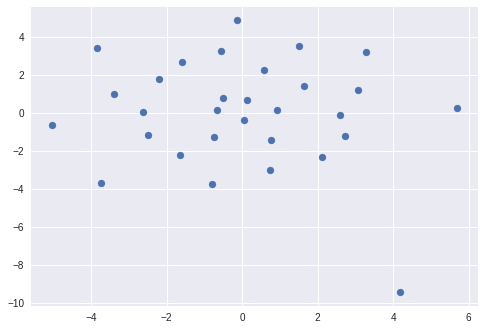

In [33]:
plt.scatter(x=pta_transformed[:, 0], y=pta_transformed[:, 1])
plt.show()

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

In [34]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код


##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [35]:
# Ваш код


Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [36]:
print "http://yandex.ru"   # получится кликабельная ссылка

SyntaxError: Missing parentheses in call to 'print'. Did you mean print("http://yandex.ru"   # получится кликабельная ссылка)? (994542665.py, line 1)

Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [ ]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [ ]:
# Ваш код


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 